<sub>Developed by SeongKu Kang, August 2025 — Do not distribute</sub>

# Intro to GNN

In this notebook, we will explore **Graph Neural Networks (GNNs)** through a hands-on example using the **Cora citation network dataset**.  
Our goal is to build an intuitive understanding of how GNNs work, how they process graph-structured data, and how to implement a simple Graph Convolutional Network (GCN) for node classification.

---

### What is a GNN?

- Unlike traditional machine learning models that operate on independent data points, GNNs are designed to work on **graph-structured data**.
- A graph consists of:
  - **Nodes (vertices):** entities in the dataset  
  - **Edges:** relationships or connections between nodes  
  - **Node features:** descriptive attributes of each node  
- GNNs learn meaningful node representations by **aggregating and transforming information from neighboring nodes**.

---

### Dataset: Cora Citation Network

- The **Cora dataset** is a widely used benchmark in graph learning research.
- It consists of:
  - **2,708 nodes:** scientific papers  
  - **5,429 edges:** citation links between papers  
  - **1,433-dimensional node features:** bag-of-words representation of each paper  
  - **7 labels:** research categories such as Neural Networks, Reinforcement Learning, etc.  

This dataset is especially popular because it is relatively small yet captures the essential challenges of graph-based learning.

---

### Task: Node Classification

- The objective is to classify each paper into its correct research category.
- We will train a **2-layer GCN** that leverages both node features and the graph structure.
- Dataset split:
  - Training set: 60% of nodes  
  - Validation set: 20% of training nodes (for early stopping and hyperparameter tuning)  
  - Test set: 40% of nodes (for final evaluation)  

In [1]:
import json
from tqdm import tqdm
from pathlib import Path
from utils import * 
import copy
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

###  Loading the Cora Dataset

The **Cora citation network** is provided in two text files:
1. `cora.content`: Each row corresponds to a paper (node) and contains:
  - Paper ID  
  - 1,433 binary features (bag-of-words representation)  
  - Paper label (research category)  

2. `cora.cites`  
  Each row represents a citation link (edge) between two papers.

---

### Data Structures we use

1. **Feature matrix**  $X \in \mathbb{R}^{N \times d}$  
   - $N = 2708$ (number of nodes/papers), $d = 1433$ (feature dimension)  
   - Each row corresponds to one paper's bag-of-words features.


2. **Label vector** $y \in \{0, \dots, C-1\}^N$  
   - $C = 7$ (number of research categories)  
   - Each entry is the label of a paper.


3. **Normalized adjacency matrix**  $\hat{A} \in \mathbb{R}^{N \times N}$  
   - Represents graph connectivity.  
   - We start with an adjacency matrix $A$ where:  

$$A_{ij} =
\begin{cases}
1 & \text{if nodes } i \text{ and } j \text{ are connected (or } i=j \text{ for self-loop)} \\
0 & \text{otherwise}
\end{cases}$$  

Then normalize it using: $\hat{A} = D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$, where $D$ is the degree matrix.

---

### Returned Tensors

- `X` : Feature matrix (\([2708, 1433]\))  
- `y` : Labels (\([2708]\))  
- `A_hat` : Normalized adjacency matrix (\([2708, 2708]\))  


In [2]:
def load_cora(content_path="cora.content", cites_path="cora.cites"):
    # --- 1) Load node features & labels ---
    idx_features_labels = np.genfromtxt(content_path, dtype=str)        # Each row: [paper_id, word_attributes..., class_label]
    features = np.array(idx_features_labels[:, 1:-1], dtype=np.float32) # Node features (1433-dim bag-of-words)
    labels_raw = idx_features_labels[:, -1]                             # Raw labels (e.g., "Neural_Networks")

    classes = sorted(set(labels_raw))                                   # Unique class names
    label_map = {c: i for i, c in enumerate(classes)}                   # Map class → integer
    labels = np.array([label_map[l] for l in labels_raw], dtype=np.int64) # Integer labels

    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)           # Original paper IDs
    idx_map = {j: i for i, j in enumerate(idx)}                         # Map paper ID → row index

    # --- 2) Load edges ---
    edges_unordered = np.genfromtxt(cites_path, dtype=np.int32)         # Each row: [citing_paper_id, cited_paper_id]
    edges = np.array(list(map(lambda x: [idx_map[x[0]], idx_map[x[1]]], edges_unordered)))  

    # --- 3) Build adjacency matrix ---
    n_nodes = labels.shape[0]                                           # Total number of nodes
    A = np.eye(n_nodes, dtype=np.float32)                               # Identity matrix (self-loops)
    for i, j in edges:
        A[i, j] = 1                                                     # Add edge i → j
        A[j, i] = 1                                                     # Add edge j → i (undirected)

    D = np.sum(A, axis=1)                                               # Degree matrix (node degrees)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(D + 1e-8))                       # D^(-1/2)
    A_hat = D_inv_sqrt @ A @ D_inv_sqrt                                 # Normalized adjacency: Â = D^(-1/2) * A * D^(-1/2)

    return torch.from_numpy(features), torch.from_numpy(labels), torch.from_numpy(A_hat).float()
    
# === Load Cora dataset ===
ROOT = Path("dataset/cora-data")
X, y, A_hat = load_cora(ROOT / "cora.content", ROOT / "cora.cites")

num_nodes   = X.shape[0]              # 2708 nodes
input_dim   = X.shape[1]              # 1433 features per node
num_classes = len(y.unique())         # 7 classes

print(X.shape, y.shape, A_hat.shape)

torch.Size([2708, 1433]) torch.Size([2708]) torch.Size([2708, 2708])


In [3]:
# --- Split dataset into train/val/test ---
idx = torch.randperm(num_nodes)                               # Random permutation of node indices

train_size = int(0.6 * num_nodes)                             # 60% for training
val_size   = int(0.2 * num_nodes)                             # 20% for validation
test_size  = num_nodes - train_size - val_size                # Remaining 20% for test

train_idx = idx[:train_size]                                  
val_idx   = idx[train_size:train_size+val_size]               
test_idx  = idx[train_size+val_size:]                         

# --- Move data & indices to device ---
train_idx, val_idx, test_idx = train_idx.to(device), val_idx.to(device), test_idx.to(device)
X, y = X.to(device), y.to(device)

In [4]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, X, y, split_idx, device="cpu"):
    """
    Evaluate GCN model on given split (train/val/test).
    
    Args:
        model: trained model
        X: [num_nodes, input_dim] full feature matrix
        y: [num_nodes] full labels
        split_idx: indices for the split (e.g., val_idx, test_idx)
        device: "cpu" or "cuda"
    """
    model.eval()
    with torch.no_grad():
        logits = model(X.to(device))
        preds = torch.argmax(logits, dim=1).cpu()

    split_idx = split_idx.cpu()
    labels = y[split_idx].cpu().numpy()
    preds  = preds[split_idx].numpy()

    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro", zero_division=0)

    return {"accuracy": acc, "f1_macro": f1_macro}

In [5]:
results_dict = {'valid':{}, 'test': {}}

## [Part A]: MLP Classifier (Baseline)

An MLP takes only the **feature matrix** $X$ as input and ignores the graph adjacency. 

In [6]:
import torch.nn as nn
class MLPClassifier(nn.Module):
    """
    A simple 2-layer MLP classifier for node classification.

    Input:
        X : [N, d_in]   (node features: N nodes, each with d_in features)
    Output:
        logits : [N, C] (class scores for each node across C classes)

    Architecture:
        X → Linear(d_in → hidden_dim) → ReLU → Dropout → Linear(hidden_dim → C)
    """
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = dropout

    def forward(self, x):
        h = F.relu(self.fc1(x))                      # hidden representation
        h = F.dropout(h, p=self.dropout, training=self.training)
        return self.fc2(h)                           # class logits

In [7]:
model = MLPClassifier(input_dim=input_dim, hidden_dim=64, num_classes=num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

In [8]:
best_val_acc = -1
best_model_state = None
patience = 5
patience_counter = 0

val_acc_list = []
test_acc_list = []

EPOCHS = 500

for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad()

    # === Forward on full graph ===
    logits = model(X.to(device))
    loss = F.cross_entropy(logits[train_idx], y[train_idx].to(device))

    # === Backprop ===
    loss.backward()
    optimizer.step()

    print(f"[Epoch {epoch}] Train Loss: {loss.item():.4f}")

    # === Validation ===
    val_result = evaluate(model, X, y, val_idx, device=device)
    val_acc = val_result["accuracy"]
    val_acc_list.append(val_acc)

    is_improved = val_acc > best_val_acc
    print_eval_result(val_result, stage="val", is_improved=is_improved)

    # === Test ===
    test_result = evaluate(model, X, y, test_idx, device=device)
    test_acc = test_result["accuracy"]
    test_acc_list.append(test_acc)
    print_eval_result(test_result, stage="test")

    # === Update best model ===
    if is_improved:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    # === Early stopping ===
    if patience_counter >= patience:
        print(f"[Early Stopping] No improvement for {patience} consecutive epochs.")
        break
    print()

[Epoch 1] Train Loss: 1.9264
[VAL ] Acc: 0.2884 | F1-macro: 0.0639 *
[TEST] Acc: 0.2707 | F1-macro: 0.0609

[Epoch 2] Train Loss: 1.8188
[VAL ] Acc: 0.2921 | F1-macro: 0.0701 *
[TEST] Acc: 0.2744 | F1-macro: 0.0683

[Epoch 3] Train Loss: 1.6936
[VAL ] Acc: 0.3161 | F1-macro: 0.1068 *
[TEST] Acc: 0.2891 | F1-macro: 0.0942

[Epoch 4] Train Loss: 1.5612
[VAL ] Acc: 0.3900 | F1-macro: 0.2051 *
[TEST] Acc: 0.3610 | F1-macro: 0.1961

[Epoch 5] Train Loss: 1.4137
[VAL ] Acc: 0.4640 | F1-macro: 0.2906 *
[TEST] Acc: 0.4715 | F1-macro: 0.3408

[Epoch 6] Train Loss: 1.2635
[VAL ] Acc: 0.5582 | F1-macro: 0.4054 *
[TEST] Acc: 0.5580 | F1-macro: 0.4399

[Epoch 7] Train Loss: 1.1144
[VAL ] Acc: 0.6433 | F1-macro: 0.5380 *
[TEST] Acc: 0.6298 | F1-macro: 0.5398

[Epoch 8] Train Loss: 0.9792
[VAL ] Acc: 0.6876 | F1-macro: 0.6040 *
[TEST] Acc: 0.6924 | F1-macro: 0.6336

[Epoch 9] Train Loss: 0.8501
[VAL ] Acc: 0.7190 | F1-macro: 0.6510 *
[TEST] Acc: 0.7385 | F1-macro: 0.7092

[Epoch 10] Train Loss: 0.743

In [9]:
# === Load best model for final evaluation ===
model.load_state_dict(best_model_state)
final_test_result = evaluate(model, X, y, test_idx, device=device)
print_eval_result(final_test_result, stage="final_test")

results_dict['valid']['cora_MLP'] = val_acc_list[:]
results_dict['test']['cora_MLP'] = test_acc_list[:]

[FINAL_TEST] Acc: 0.7624 | F1-macro: 0.7440


## [Part B]: GNN Classifier

Recall that a GCN layer updates node features by aggregating information from neighbors. The operation can be written as:

$$H' = \sigma( \hat{A} H W )$$

- $H \in \mathbb{R}^{N \times d_{in}}$: input node features  
- $\hat{A} \in \mathbb{R}^{N \times N}$: normalized adjacency with self-loops  
- $W \in \mathbb{R}^{d_{in} \times d_{out}}$: learnable weight matrix  
- $H' \in \mathbb{R}^{N \times d_{out}}$: output node features

---

In our implementation:
- `GCNLayer` corresponds to the transformation $H' = \hat{A} H W$  
- `GCNClassifier` stacks two GCN layers with ReLU and dropout, followed by a linear classifier that outputs class logits for each node.


In [10]:
# === Define GCN Layer ===
class GCNLayer(nn.Module):
    """
    A single Graph Convolutional Network (GCN) layer.

    Operation:
        H' = A_hat @ H @ W
        where
            H : [N, d_in]   (input node features)
            A_hat : [N, N] (normalized adjacency with self-loops)
            W : [d_in, d_out] (learnable weights)
            H' : [N, d_out] (output node features)
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.empty(in_dim, out_dim))   # learnable weight
        nn.init.xavier_uniform_(self.W)                      # Xavier initialization

    def forward(self, H, A_hat):
        return torch.matmul(torch.matmul(A_hat, H), self.W)


# === Define GCN Classifier (2-layer GCN + Linear head) ===
class GCNClassifier(nn.Module):
    """
    A 2-layer GCN followed by a linear classifier for node classification.

    Input:
        X : [N, input_dim]   (node features)
    Output:
        logits : [N, C] (class scores for each node)

    Architecture:
        X → GCN(input_dim → hidden_dim) → ReLU → Dropout →
            GCN(hidden_dim → hidden_dim) → ReLU → Dropout →
            Linear(hidden_dim → C)
    """
    def __init__(self, input_dim, hidden_dim, num_classes, A_hat, dropout=0.5):
        super().__init__()
        self.gcn1 = GCNLayer(input_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, hidden_dim)
        self.fc   = nn.Linear(hidden_dim, num_classes)

        self.dropout = dropout
        self.register_buffer("A_hat", A_hat)  # keep adjacency as buffer (not a parameter)

    def forward(self, X):
        H = F.relu(self.gcn1(X, self.A_hat))
        H = F.dropout(H, p=self.dropout, training=self.training)

        H = F.relu(self.gcn2(H, self.A_hat))
        H = F.dropout(H, p=self.dropout, training=self.training)

        logits = self.fc(H)
        return logits

In [11]:
model = GCNClassifier(input_dim=input_dim, hidden_dim=64, num_classes=num_classes, A_hat=A_hat).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

In [12]:
best_val_acc = -1
best_model_state = None
patience = 5
patience_counter = 0

val_acc_list = []
test_acc_list = []

EPOCHS = 500

for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad()

    # === Forward on full graph ===
    logits = model(X.to(device))
    loss = F.cross_entropy(logits[train_idx], y[train_idx].to(device))

    # === Backprop ===
    loss.backward()
    optimizer.step()

    print(f"[Epoch {epoch}] Train Loss: {loss.item():.4f}")

    # === Validation ===
    val_result = evaluate(model, X, y, val_idx, device=device)
    val_acc = val_result["accuracy"]
    val_acc_list.append(val_acc)

    is_improved = val_acc > best_val_acc
    print_eval_result(val_result, stage="val", is_improved=is_improved)

    # === Test ===
    test_result = evaluate(model, X, y, test_idx, device=device)
    test_acc = test_result["accuracy"]
    test_acc_list.append(test_acc)
    print_eval_result(test_result, stage="test")

    # === Update best model ===
    if is_improved:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    # === Early stopping ===
    if patience_counter >= patience:
        print(f"[Early Stopping] No improvement for {patience} consecutive epochs.")
        break
    print()

[Epoch 1] Train Loss: 1.9471
[VAL ] Acc: 0.2884 | F1-macro: 0.0639 *
[TEST] Acc: 0.2707 | F1-macro: 0.0609

[Epoch 2] Train Loss: 1.8757
[VAL ] Acc: 0.2884 | F1-macro: 0.0639
[TEST] Acc: 0.2707 | F1-macro: 0.0609

[Epoch 3] Train Loss: 1.7613
[VAL ] Acc: 0.2884 | F1-macro: 0.0639
[TEST] Acc: 0.2707 | F1-macro: 0.0609

[Epoch 4] Train Loss: 1.6581
[VAL ] Acc: 0.2884 | F1-macro: 0.0639
[TEST] Acc: 0.2707 | F1-macro: 0.0609

[Epoch 5] Train Loss: 1.5314
[VAL ] Acc: 0.4769 | F1-macro: 0.3352 *
[TEST] Acc: 0.4659 | F1-macro: 0.3144

[Epoch 6] Train Loss: 1.3817
[VAL ] Acc: 0.7098 | F1-macro: 0.5508 *
[TEST] Acc: 0.7109 | F1-macro: 0.5672

[Epoch 7] Train Loss: 1.2387
[VAL ] Acc: 0.7468 | F1-macro: 0.5853 *
[TEST] Acc: 0.7293 | F1-macro: 0.5765

[Epoch 8] Train Loss: 1.0960
[VAL ] Acc: 0.7689 | F1-macro: 0.6382 *
[TEST] Acc: 0.7532 | F1-macro: 0.6275

[Epoch 9] Train Loss: 0.9592
[VAL ] Acc: 0.7800 | F1-macro: 0.6630 *
[TEST] Acc: 0.7827 | F1-macro: 0.6776

[Epoch 10] Train Loss: 0.8412
[VAL

In [13]:
# === Load best model for final evaluation ===
model.load_state_dict(best_model_state)
final_test_result = evaluate(model, X, y, test_idx, device=device)
print_eval_result(final_test_result, stage="final_test")

results_dict['valid']['cora_GNN'] = val_acc_list[:]
results_dict['test']['cora_GNN'] = test_acc_list[:]

[FINAL_TEST] Acc: 0.8785 | F1-macro: 0.8592


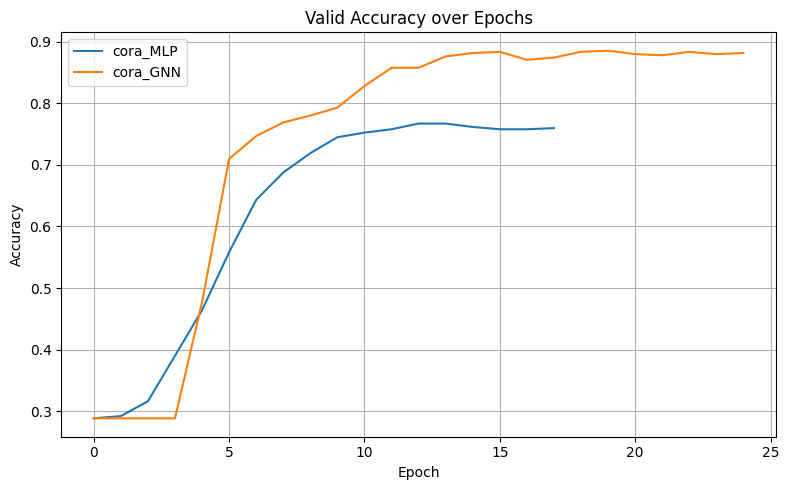

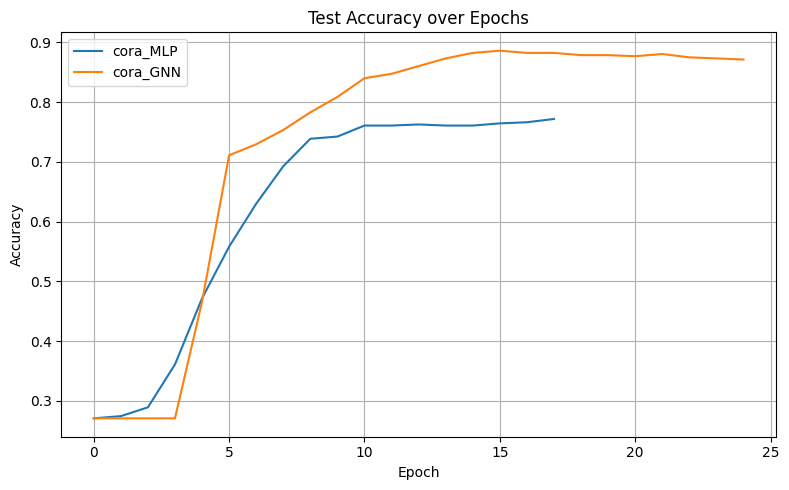

In [14]:
plot_results(results_dict, split="valid")
plot_results(results_dict, split="test")